In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb

In [2]:
# 全量数据

train_data = pd.read_csv('d:/data_format1/train_format1.csv')
test_data = pd.read_csv('d:/data_format1/test_format1.csv')
user_info = pd.read_csv('d:/data_format1/user_info_format1.csv')
user_log = pd.read_csv('d:/data_format1/user_log_format1.csv')


In [3]:
# 样本提取
'''
user_info.set_index('user_id', inplace=True)
user_log.set_index('user_id', inplace=True)
train_data_sample = train_data.sample(n=15000)
test_data_sample = test_data.sample(n=5000)
sample_user_id = train_data_sample['user_id'].tolist() + test_data_sample['user_id'].tolist()
user_info_sample = user_info.loc[sample_user_id]
user_log_sample = user_log.loc[sample_user_id]
train_data_sample.set_index('user_id', inplace=True)
test_data_sample.set_index('user_id', inplace=True)
'''

"\nuser_info.set_index('user_id', inplace=True)\nuser_log.set_index('user_id', inplace=True)\ntrain_data_sample = train_data.sample(n=15000)\ntest_data_sample = test_data.sample(n=5000)\nsample_user_id = train_data_sample['user_id'].tolist() + test_data_sample['user_id'].tolist()\nuser_info_sample = user_info.loc[sample_user_id]\nuser_log_sample = user_log.loc[sample_user_id]\ntrain_data_sample.set_index('user_id', inplace=True)\ntest_data_sample.set_index('user_id', inplace=True)\n"

In [4]:
# 保存样本
'''
train_data_sample.to_csv('./sample/train_data_sample.csv')
test_data_sample.to_csv('./sample/test_data_sample.csv')
user_info_sample.to_csv('./sample/user_info_sample.csv')
user_log_sample.to_csv('./sample/user_log_sample.csv')
'''

"\ntrain_data_sample.to_csv('./sample/train_data_sample.csv')\ntest_data_sample.to_csv('./sample/test_data_sample.csv')\nuser_info_sample.to_csv('./sample/user_info_sample.csv')\nuser_log_sample.to_csv('./sample/user_log_sample.csv')\n"

In [5]:
# 加载样本
'''
train_data = pd.read_csv('./sample/train_data_sample.csv')
test_data = pd.read_csv('./sample/test_data_sample.csv')
user_info = pd.read_csv('./sample/user_info_sample.csv')
user_log = pd.read_csv('./sample/user_log_sample.csv')
'''

"\ntrain_data = pd.read_csv('./sample/train_data_sample.csv')\ntest_data = pd.read_csv('./sample/test_data_sample.csv')\nuser_info = pd.read_csv('./sample/user_info_sample.csv')\nuser_log = pd.read_csv('./sample/user_log_sample.csv')\n"

In [3]:
user_log.rename(columns={'seller_id': 'merchant_id'}, inplace=True)

In [4]:
# 数据清洗
user_log['brand_id'].fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int64')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%H%M')
user_info['age_range'].fillna(0, inplace=True)
user_info = user_info.replace([8], [7])
user_info['age_range'] = user_info['age_range'].astype('int64')
user_info['gender'].fillna(2, inplace=True)
user_info['gender'] = user_info['gender'].astype('int64')

In [5]:
print(train_data.info())
print(user_info.info())
print(user_log.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    424170 non-null  int64
 1   age_range  424170 non-null  int64
 2   gender     424170 non-null  int64
dtypes: int64(3)
memory usage: 9.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Non-Null Count     Dtype         
---  ------       --------------     -----         
 0   user_id      54925330 non-null  int64         
 1   item_id      549253

In [6]:
train_data['origin'] = 'train'
test_data['origin'] = 'test'
matrix = pd.concat([train_data, test_data], ignore_index=True, sort=False)
matrix.drop('prob', axis=1, inplace=True)
matrix = matrix.merge(user_info, on='user_id', how='left')

In [7]:
# 用户特征处理
groups = user_log.groupby(['user_id'])
temp = groups.size().reset_index().rename(columns={0: 'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0: 'u7', 1: 'u8', 2: 'u9', 3: 'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')

# 商户特征处理
groups = user_log.groupby(['merchant_id'])
temp = groups.size().reset_index().rename(columns={0: 'm1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id': 'm2', 'item_id': 'm3', 'cat_id': 'm4', 'brand_id': 'm5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0: 'm6', 1: 'm7', 2: 'm8', 3: 'm9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')
temp = train_data[train_data['label'] == -1].groupby('merchant_id').size().reset_index().rename(columns={0: 'm10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

d:\anaconda3\envs\python3.7\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [8]:
groups = user_log.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0: 'um1'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id': 'um2', 'cat_id': 'um3', 'brand_id': 'um4'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0: 'um5', 1: 'um6', 2: 'um7', 3: 'um8'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('first', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['first']).dt.seconds/3600
temp.drop(['last', 'first'], axis=1, inplace=True)
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')

d:\anaconda3\envs\python3.7\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [9]:
matrix['r1'] = matrix['u9'] / matrix['u7']
matrix['r2'] = matrix['m8'] / matrix['m6']
matrix['r3'] = matrix['um7'] / matrix['um5']
matrix.fillna(0, inplace=True)
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='gen')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)

In [10]:
train_data = matrix[matrix['origin'] == 'train'].drop('origin', axis=1)
test = matrix[matrix['origin'] == 'test'].drop(['origin', 'label'], axis=1)
x_train, y_train = train_data.drop('label', axis=1), train_data['label']

In [11]:
train_x, vali_x, train_y, vali_y = train_test_split(x_train, y_train, test_size=0.2)
params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.01, 'max_depth': 15, 'feature_fraction': 0.8, 'bagging_fraction': 0.9,
         'bagging_freq': 8, 'lambda_l1': 0.6, 'lambda_l2': 0}
trn_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(vali_x, label=vali_y)
model = lgb.train(params, trn_data, valid_sets=[trn_data, val_data], num_boost_round=10000, early_stopping_rounds=200, verbose_eval=25)

Training until validation scores don't improve for 200 rounds
[25]	training's auc: 0.656411	valid_1's auc: 0.652615
[50]	training's auc: 0.65992	valid_1's auc: 0.654165
[75]	training's auc: 0.664561	valid_1's auc: 0.655602
[100]	training's auc: 0.66935	valid_1's auc: 0.658082
[125]	training's auc: 0.67481	valid_1's auc: 0.661261
[150]	training's auc: 0.678826	valid_1's auc: 0.662735
[175]	training's auc: 0.681742	valid_1's auc: 0.663645
[200]	training's auc: 0.68524	valid_1's auc: 0.665343
[225]	training's auc: 0.689222	valid_1's auc: 0.667035
[250]	training's auc: 0.693254	valid_1's auc: 0.668601
[275]	training's auc: 0.696485	valid_1's auc: 0.669477
[300]	training's auc: 0.699823	valid_1's auc: 0.671013
[325]	training's auc: 0.702806	valid_1's auc: 0.671569
[350]	training's auc: 0.705809	valid_1's auc: 0.672312
[375]	training's auc: 0.708663	valid_1's auc: 0.673
[400]	training's auc: 0.711499	valid_1's auc: 0.673539
[425]	training's auc: 0.714093	valid_1's auc: 0.67405
[450]	training

In [12]:
prob = model.predict(test)
test_data['prob'] = pd.Series(prob)
test_data.drop(['origin'], axis=1, inplace=True)

In [16]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np
import matplotlib.pyplot as plt

train_features = train_data.iloc[:, 3:]
dvec=DictVectorizer(sparse=True)
train_features=dvec.fit_transform(train_features.to_dict(orient='record'))

In [17]:
def show_feature_importance(feature_list, feature_importance):
	# 设定阈值
	fi_threshold = 20
	# 重要特征的下标
	important_idx = np.where(feature_importance > fi_threshold)[0]
	# 特征名称
	important_features = [feature_list[i] for i in important_idx]
	# 重要特征
	sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
	# 可视化
	pos = np.arange(sorted_idx.shape[0]) + 0.5
	plt.subplot(1, 2, 2)
	plt.title('Feature Importance')
	plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], color='r',align='center')
	plt.yticks(pos, [important_features[i] for i in sorted_idx[::-1]])
	plt.xlabel('Relative Importance')
	plt.draw()
	plt.show()

In [24]:
feature_importance = coef = model.feature_importance()
feature_importance = 100.0 * (feature_importance / feature_importance.max())

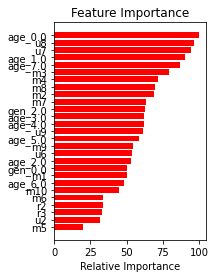

In [25]:
show_feature_importance(dvec.feature_names_, feature_importance)